In [1]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.listdir('breast-cancer-detection')

['test.csv', 'sample-submission.csv', 'train.csv']

In [3]:
data = pd.read_csv('breast-cancer-detection/train.csv')
data.columns

Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32',
       'diagnosis'],
      dtype='object')

In [4]:
data = data.drop(['Unnamed: 32','id'], axis = 1)
data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,11.80,16.58,78.99,432.0,0.10910,0.17000,0.16590,0.07415,0.2678,0.07371,...,26.38,91.93,591.7,0.1385,0.4092,0.45040,0.18650,0.5774,0.10300,M
1,10.26,14.71,66.20,321.6,0.09882,0.09159,0.03581,0.02037,0.1633,0.07005,...,19.48,70.89,357.1,0.1360,0.1636,0.07162,0.04074,0.2434,0.08488,B
2,15.30,25.27,102.40,732.4,0.10820,0.16970,0.16830,0.08751,0.1926,0.06540,...,36.71,149.30,1269.0,0.1641,0.6110,0.63350,0.20240,0.4027,0.09876,M
3,12.47,17.31,80.45,480.1,0.08928,0.07630,0.03609,0.02369,0.1526,0.06046,...,24.34,92.82,607.3,0.1276,0.2506,0.20280,0.10530,0.3035,0.07661,B
4,15.32,17.27,103.20,713.3,0.13350,0.22840,0.24480,0.12420,0.2398,0.07596,...,22.66,119.80,928.8,0.1765,0.4503,0.44290,0.22290,0.3258,0.11910,M


In [5]:
for col in data.columns:
    if data[col].dtypes == 'object':
        le = preprocessing.LabelEncoder()
        data[col] = le.fit_transform(data[col])
    else:
        scaler = preprocessing.StandardScaler()
        data[col] = scaler.fit_transform(np.array(data[col]).reshape(-1, 1))

<AxesSubplot:>

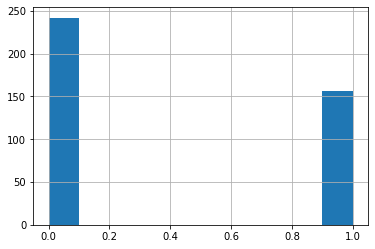

In [6]:
data['diagnosis'].hist()

/Users/khangtran/opt/anaconda3/envs/assignment/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/khangtran/opt/anaconda3/envs/assignment/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/khangtran/opt/anaconda3/envs/assignment/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

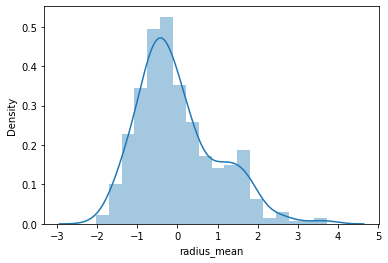

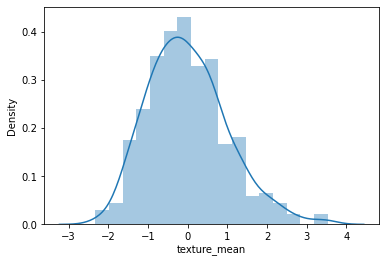

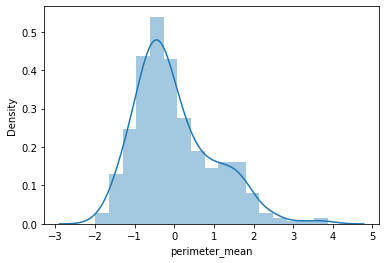

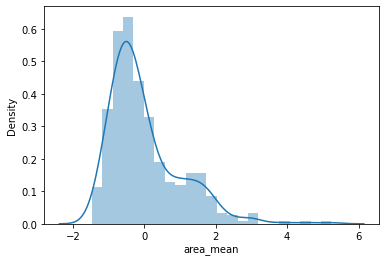

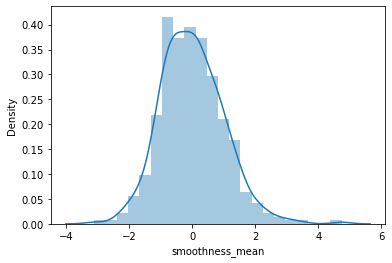

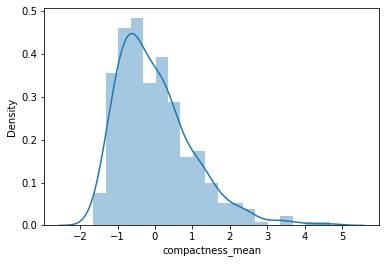

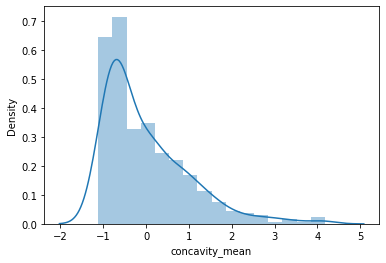

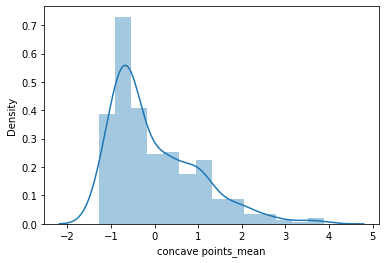

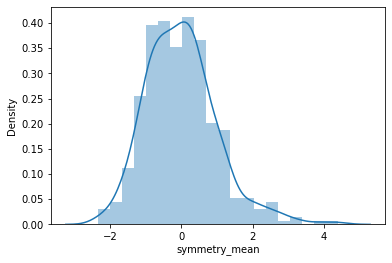

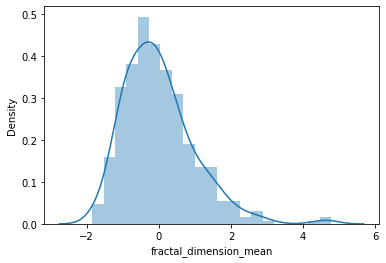

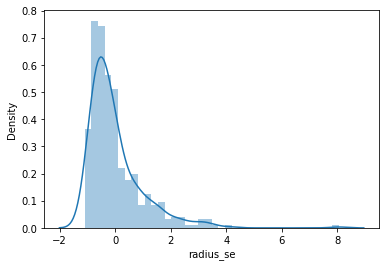

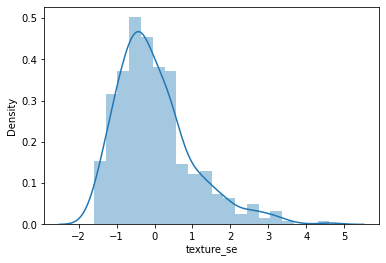

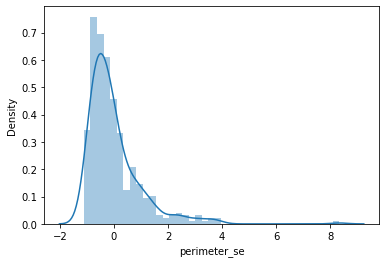

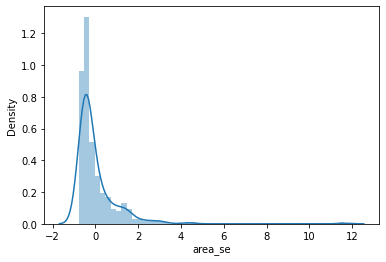

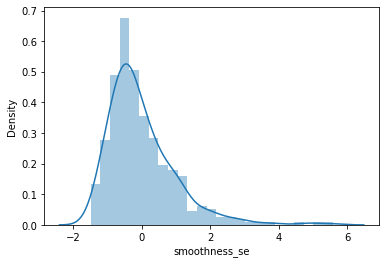

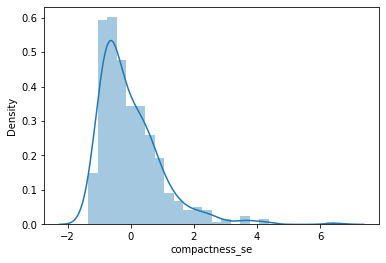

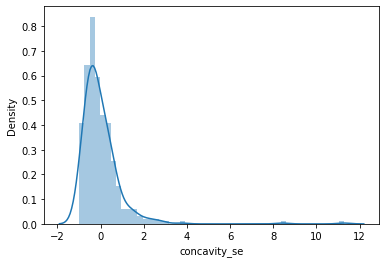

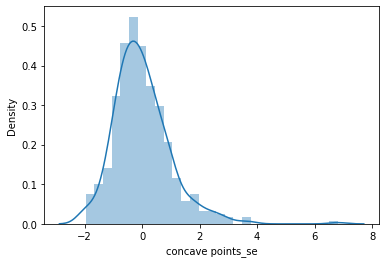

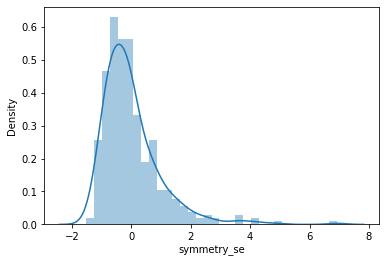

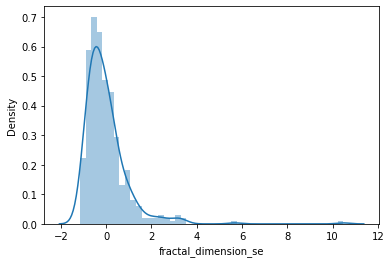

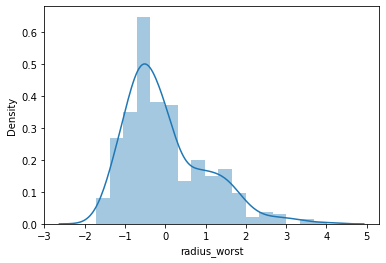

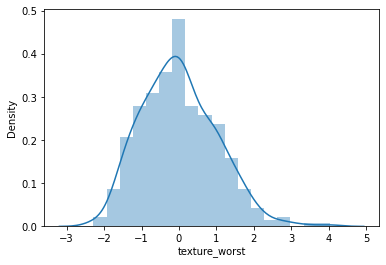

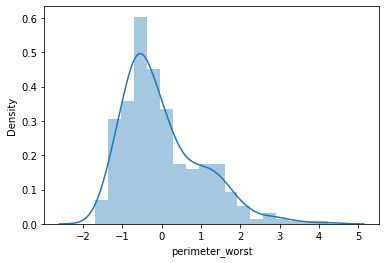

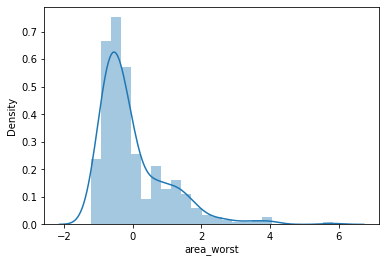

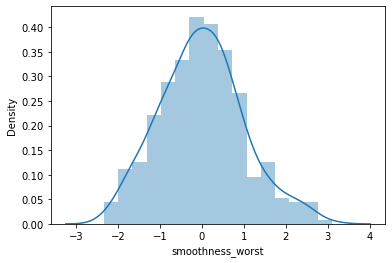

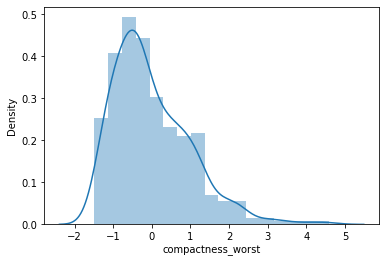

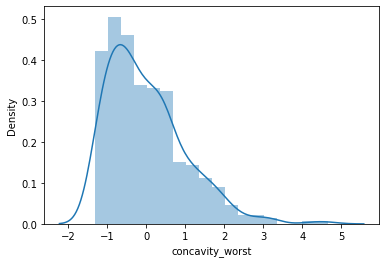

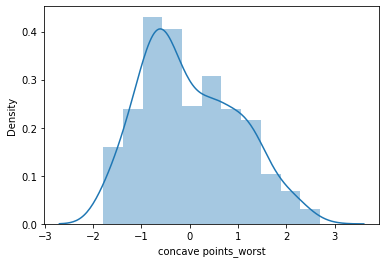

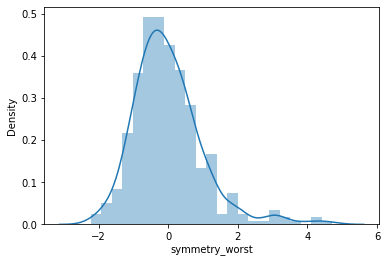

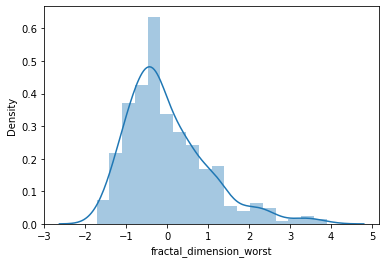

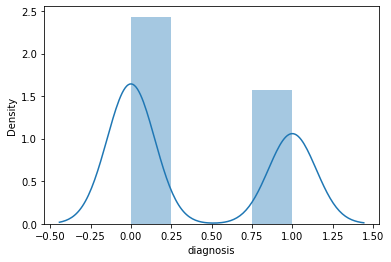

In [7]:
for column in data.columns:
    plt.figure()
    sns.distplot(data[column])

In [8]:
data.shape

(398, 31)

In [9]:
X, y = np.array(data[data.columns[:-1]]), np.array(data[data.columns[-1]])

In [10]:
def metric(tn, fp, fn, tp):
    result = []
    tpr = tp/(tp+fn)
    result.append(tpr)
    tnr = tn/(tn+fp)
    result.append(tnr)
    fpr = fp/(tn+fp)
    result.append(fpr)
    fnr = fn/(tp+fn)
    result.append(fnr)
    recall = tp/(tp+fn)
    result.append(recall)
    precision = tp/(tp+fp)
    result.append(precision)
    f1 = (2*tp)/(2*tp+fp+fn)
    result.append(f1)
    acc = (tp+tn)/(tp+fp+fn+tn)
    result.append(acc)
    err = (fp+fn)/(tp+fp+fn+tn)
    result.append(err)
    bacc = (tpr+tnr)/2
    result.append(bacc)
    tss = tp/(tp+fn) - fp/(fp+tn)
    result.append(tss)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    result.append(hss)
    return np.array(result)

In [11]:
kf = KFold(n_splits=10, random_state=123)
fold = 0
svc_mean = np.zeros(12)
rf_mean = np.zeros(12)
gnb_mean = np.zeros(12)
for train_index, test_index in kf.split(X, y):
    fold += 1
    print("Fold", str(fold))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #SVM
    print("\tSVM model result:")
    svc = SVC(gamma='auto')
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svc).ravel()
    svc_result = metric(tn, fp, fn, tp)
    svc_mean += svc_result
    print("\t\tTrue positive rate:", svc_result[0])
    print("\t\tTrue negative rate:", svc_result[1])
    print("\t\tFalse positive rate:", svc_result[2])
    print("\t\tFalse negative rate:", svc_result[3])
    print("\t\tRecall:", svc_result[4])
    print("\t\tPrecision:", svc_result[5])
    print("\t\tF1:", svc_result[6])
    print("\t\tAccuracy:", svc_result[7])
    print("\t\tError Rate:", svc_result[8]) 
    print("\t\tBalance Accuracy:", svc_result[9])
    print("\t\tTrue skill statistics:", svc_result[10])
    print("\t\tHeidke skill score:", svc_result[11])
    #Random Forrest
    print("\tRandom Forest model result:")
    rf = RandomForestClassifier(max_depth=5, random_state=0)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
    rf_result = metric(tn, fp, fn, tp)
    rf_mean += rf_result
    print("\t\tTrue positive rate:", rf_result[0])
    print("\t\tTrue negative rate:", rf_result[1])
    print("\t\tFalse positive rate:", rf_result[2])
    print("\t\tFalse negative rate:", rf_result[3])
    print("\t\tRecall:", rf_result[4])
    print("\t\tPrecision:", rf_result[5])
    print("\t\tF1:", rf_result[6])
    print("\t\tAccuracy:", rf_result[7])
    print("\t\tError Rate:", rf_result[8]) 
    print("\t\tBalance Accuracy:", rf_result[9])
    print("\t\tTrue skill statistics:", rf_result[10])
    print("\t\tHeidke skill score:", rf_result[11])
    #Naive Bayes
    print("\tNaive Bayes model result:")
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred_gnb = gnb.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gnb).ravel()
    gnb_result = metric(tn, fp, fn, tp)
    gnb_mean += gnb_result
    print("\t\tTrue positive rate:", gnb_result[0])
    print("\t\tTrue negative rate:", gnb_result[1])
    print("\t\tFalse positive rate:", gnb_result[2])
    print("\t\tFalse negative rate:", gnb_result[3])
    print("\t\tRecall:", gnb_result[4])
    print("\t\tPrecision:", gnb_result[5])
    print("\t\tF1:", gnb_result[6])
    print("\t\tAccuracy:", gnb_result[7])
    print("\t\tError Rate:", gnb_result[8]) 
    print("\t\tBalance Accuracy:", gnb_result[9])
    print("\t\tTrue skill statistics:", gnb_result[10])
    print("\t\tHeidke skill score:", gnb_result[11])
#     print(y_pred_svc.shape, y_pred_rf.shape, y_pred_gnb.shape)

/Users/khangtran/opt/anaconda3/envs/assignment/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Fold 1
	SVM model result:
		True positive rate: 1.0
		True negative rate: 1.0
		False positive rate: 0.0
		False negative rate: 0.0
		Recall: 1.0
		Precision: 1.0
		F1: 1.0
		Accuracy: 1.0
		Error Rate: 0.0
		Balance Accuracy: 1.0
		True skill statistics: 1.0
		Heidke skill score: 1.0
	Random Forest model result:
		True positive rate: 0.9411764705882353
		True negative rate: 1.0
		False positive rate: 0.0
		False negative rate: 0.058823529411764705
		Recall: 0.9411764705882353
		Precision: 1.0
		F1: 0.9696969696969697
		Accuracy: 0.975
		Error Rate: 0.025
		Balance Accuracy: 0.9705882352941176
		True skill statistics: 0.9411764705882353
		Heidke skill score: 0.9484536082474226
	Naive Bayes model result:
		True positive rate: 0.8823529411764706
		True negative rate: 1.0
		False positive rate: 0.0
		False negative rate: 0.11764705882352941
		Recall: 0.8823529411764706
		Precision: 1.0
		F1: 0.9375
		Accuracy: 0.95
		Error Rate: 0.05
		Balance Accuracy: 0.9411764705882353
		True skill sta

In [12]:
svc_mean /= 10
rf_mean /= 10
gnb_mean /= 10

In [13]:
print("Overall result for SVM model:")
print("\tTrue positive rate:", svc_mean[0])
print("\tTrue negative rate:", svc_mean[1])
print("\tFalse positive rate:", svc_mean[2])
print("\tFalse negative rate:", svc_mean[3])
print("\tRecall:", svc_mean[4])
print("\tPrecision:", svc_mean[5])
print("\tF1:", svc_mean[6])
print("\tAccuracy:", svc_mean[7])
print("\tError Rate:", svc_mean[8]) 
print("\tBalance Accuracy:", svc_mean[9])
print("\tTrue skill statistics:", svc_mean[10])
print("\tHeidke skill score:", svc_mean[11])

Overall result for SVM model:
	True positive rate: 0.9629435579899976
	True negative rate: 0.9743915343915344
	False positive rate: 0.025608465608465608
	False negative rate: 0.03705644201000238
	Recall: 0.9629435579899976
	Precision: 0.9633755133755134
	F1: 0.9620123660123661
	Accuracy: 0.9698717948717949
	Error Rate: 0.030128205128205132
	Balance Accuracy: 0.968667546190766
	True skill statistics: 0.9373350923815321
	Heidke skill score: 0.9359636913678747


In [14]:
print("Overall result for Random Forest model:")
print("\tTrue positive rate:", rf_mean[0])
print("\tTrue negative rate:", rf_mean[1])
print("\tFalse positive rate:", rf_mean[2])
print("\tFalse negative rate:", rf_mean[3])
print("\tRecall:", rf_mean[4])
print("\tPrecision:", rf_mean[5])
print("\tF1:", rf_mean[6])
print("\tAccuracy:", rf_mean[7])
print("\tError Rate:", rf_mean[8]) 
print("\tBalance Accuracy:", rf_mean[9])
print("\tTrue skill statistics:", rf_mean[10])
print("\tHeidke skill score:", rf_mean[11])

Overall result for Random Forest model:
	True positive rate: 0.9427600486888412
	True negative rate: 0.9734828617437312
	False positive rate: 0.02651713825626869
	False negative rate: 0.057239951311158735
	Recall: 0.9427600486888412
	Precision: 0.9642031171442937
	F1: 0.952650792679487
	Accuracy: 0.9623717948717948
	Error Rate: 0.03762820512820513
	Balance Accuracy: 0.9581214552162862
	True skill statistics: 0.9162429104325724
	Heidke skill score: 0.9197071842705571


In [15]:
print("Overall result for Naive Bayes model:")
print("\tTrue positive rate:", gnb_mean[0])
print("\tTrue negative rate:", gnb_mean[1])
print("\tFalse positive rate:", gnb_mean[2])
print("\tFalse negative rate:", gnb_mean[3])
print("\tRecall:", gnb_mean[4])
print("\tPrecision:", gnb_mean[5])
print("\tF1:", gnb_mean[6])
print("\tAccuracy:", gnb_mean[7])
print("\tError Rate:", gnb_mean[8]) 
print("\tBalance Accuracy:", gnb_mean[9])
print("\tTrue skill statistics:", gnb_mean[10])
print("\tHeidke skill score:", gnb_mean[11])

Overall result for Naive Bayes model:
	True positive rate: 0.8800207721415152
	True negative rate: 0.969126984126984
	False positive rate: 0.030873015873015868
	False negative rate: 0.11997922785848483
	Recall: 0.8800207721415152
	Precision: 0.957081807081807
	F1: 0.9152587428360954
	Accuracy: 0.9371794871794872
	Error Rate: 0.06282051282051282
	Balance Accuracy: 0.9245738781342496
	True skill statistics: 0.8491477562684994
	Heidke skill score: 0.8622785377668631
